# 🫁 State-of-the-Art Pneumothorax Segmentation

**A comprehensive deep learning pipeline for medical image segmentation**

### Key Features (Refined):
- ✅ **UNet++ with Attention** + ResNet34 encoder (better skip connections)
- ✅ **Max pooling mask downsampling** (preserves small pneumothorax regions!)
- ✅ **SMP's DiceLoss + BCE hybrid** (well-tested implementation)
- ✅ **256×256 resolution** (matches working baseline)
- ✅ **Grayscale normalization** (0.5, 0.5, 0.5) for medical images
- ⭐ **Kaggle winner tricks**: Class rebalancing, optimal threshold, TTA
- ✅ **Early stopping** with patience monitoring
- ✅ **Mixed precision training** for speed

**Target: Dice Coefficient > 0.85**


---
## 1. Setup & Imports


In [1]:
# Install dependencies if needed (uncomment if required)
# !pip install segmentation-models-pytorch albumentations opencv-python-headless


In [2]:
import os

# Fix HuggingFace progress bar errors in notebooks
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from typing import Tuple, Optional, Dict, List
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split, StratifiedKFold

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.2 GB


---
## 2. Configuration ⚙️

**Adjust these settings based on your GPU**


In [3]:
class Config:
    """Training configuration - adjust for your hardware."""
    
    # === DATA PATHS ===
    DATA_PATH = "siim-acr-pneumothorax"
    # DATA_PATH = "/kaggle/input/kkkkkkkkkkkkkkkkkkk/"
    TRAIN_CSV = "stage_1_train_images.csv"
    TEST_CSV = "stage_1_test_images.csv"
    IMAGES_DIR = "png_images"
    MASKS_DIR = "png_masks"
    OUTPUT_DIR = "sota_output"
    
    # === MODEL SETTINGS ===
    ENCODER = "resnet34"             # CHANGED: Simpler, proven for medical imaging
    ENCODER_WEIGHTS = "imagenet"
    ATTENTION_TYPE = "scse"          # Spatial + Channel attention
    
    # === IMAGE SETTINGS ===
    PATCH_SIZE = 256                 # CHANGED: Match original working notebook (256x256), 512 for t4
    USE_PATCHES = False               # DISABLED: Random crops can miss pneumothorax!
    
    # === TRAINING MODE ===
    # 🔄 SET THIS TO CHOOSE TRAINING MODE:
    USE_KFOLD = False                 # False = Single Split (faster), True = K-Fold CV (robust)
    N_FOLDS = 5                       # Number of folds (only if USE_KFOLD=True)
    VAL_SPLIT = 0.2                    # Validation split from train CSV (80% train, 20% val)
    # Note: Test set comes from separate TEST_CSV file
    
    # === TRAINING SETTINGS ===
    # 🔧 ADJUST THESE FOR YOUR GPU:
    BATCH_SIZE = 16                    # RTX 4060 (8GB): use 4-8, T4: use 12
    GRADIENT_ACCUMULATION = 2         # Keep simple - no accumulation needed
    EPOCHS = 30                       # Max epochs per fold
    LEARNING_RATE = 2e-5              # FIXED: Reduced for stability (was 3e-4, too high!)
    WEIGHT_DECAY = 1e-5               # Some regularization for generalization
    
    # === LOSS FUNCTION ===
    # Standard: L = BCE/Focal + λ * Dice (BCE/Focal at full weight, Dice weighted by λ)
    # Options: 'bce_dice' (default, stable) or 'focal_dice' (for extreme imbalance)
    LOSS_TYPE = 'bce_dice'            # 'bce_dice' or 'focal_dice'
    DICE_WEIGHT = 1.0                 # λ parameter: Dice weight (typical 0.5–1.0)
    FOCAL_ALPHA = 0.25                # Focal loss alpha (positive class weight)
    FOCAL_GAMMA = 2.0                 # Focal loss gamma (focusing on hard examples)
    
    # === DROPOUT (Regularization) ===
    # Recommended: 0.2 bottleneck, 0.1 decoder (SMP applies decoder dropout)
    USE_DROPOUT = True                # Enable/disable dropout
    DECODER_DROPOUT = 0.1             # Dropout in decoder blocks
    
    # === EARLY STOPPING ===
    PATIENCE = 10                     # Stop if no improvement for N epochs
    
    # === HARDWARE ===
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    NUM_WORKERS = 2                   # Data loading workers
    MIXED_PRECISION = True            # FP16 training (faster, less memory)
    
    SEED = 42

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("📋 Configuration:")
print(f"   Device: {config.DEVICE}")
print(f"   Encoder: {config.ENCODER}")
print(f"   Patch Size: {config.PATCH_SIZE}")
print(f"   Batch Size: {config.BATCH_SIZE} (effective: {config.BATCH_SIZE * config.GRADIENT_ACCUMULATION})")
print(f"   Mode: {'K-Fold CV (K=' + str(config.N_FOLDS) + ')' if config.USE_KFOLD else 'Single Split (' + str(int(config.VAL_SPLIT*100)) + '% val)'}")
print(f"   Epochs: {config.EPOCHS}")
print(f"   Learning Rate: {config.LEARNING_RATE}")

# Set seeds
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(config.SEED)


📋 Configuration:
   Device: cuda
   Encoder: resnet34
   Patch Size: 256
   Batch Size: 16 (effective: 32)
   Mode: Single Split (20% val)
   Epochs: 30
   Learning Rate: 2e-05


---
## 3. Loss Functions & Augmentation

Using **Dice-BCE Hybrid Loss** for class imbalance and **Elastic Deformations** for medical imaging


In [4]:
# Loss Functions - Using SMP's well-tested implementations
# CHANGED: Use SMP's DiceLoss (well-tested, handles per-sample correctly)
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
bce_loss = nn.BCEWithLogitsLoss()

class DiceBCELoss(nn.Module):
    """
    Standard formulation: L = BCE + λ * Dice
    
    BCE is taken at full weight (1.0), Dice is weighted by lambda.
    This is the standard convention in medical segmentation.
    
    Typical λ values: 0.5-1.0 (0.5 is common default)
    """
    def __init__(self, dice_weight=0.5):
        super().__init__()
        self.dice_weight = dice_weight  # λ parameter
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.bce_loss = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # Standard: BCE (full) + λ * Dice
        return self.bce_loss(pred, target) + self.dice_weight * self.dice_loss(pred, target)

class FocalLoss(nn.Module):
    """
    Focal Loss for handling extreme class imbalance.
    Focuses learning on hard examples (small pneumothorax regions).
    
    FL = -α(1-p)^γ * log(p)
    where p is the predicted probability, α is weighting factor, γ is focusing parameter.
    """
    def __init__(self, alpha=0.25, gamma=2.0, from_logits=True):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits
    
    def forward(self, pred, target):
        if self.from_logits:
            # Convert logits to probabilities
            pred_prob = torch.sigmoid(pred)
        else:
            pred_prob = pred
        
        # BCE term (make autocast-safe by forcing float32 and disabling autocast inside)
        with torch.cuda.amp.autocast(enabled=False):
            bce = nn.functional.binary_cross_entropy(
                pred_prob.float(),
                target.float(),
                reduction='none'
            )
        
        # Focal term: (1-p)^γ
        p_t = pred_prob * target + (1 - pred_prob) * (1 - target)  # p for positive, 1-p for negative
        focal_weight = (1 - p_t) ** self.gamma
        
        # Apply alpha weighting (alpha for positive class, 1-alpha for negative)
        alpha_t = self.alpha * target + (1 - self.alpha) * (1 - target)
        
        # Final focal loss
        focal_loss = alpha_t * focal_weight * bce
        return focal_loss.mean()

class DiceFocalLoss(nn.Module):
    """
    Standard formulation: L = Focal + λ * Dice
    
    Focal is taken at full weight (1.0), Dice is weighted by lambda.
    Best for extreme class imbalance (very small pneumothorax regions).
    
    Use when:
    - Pneumothorax regions are <1% of image
    - Missing small lesions (high false negatives)
    - BCE+Dice plateaus below target performance
    
    Typical λ values: 0.5-1.0 (0.5 is common default)
    """
    def __init__(self, dice_weight=0.5, focal_alpha=0.25, focal_gamma=2.0):
        super().__init__()
        self.dice_weight = dice_weight  # λ parameter
        self.dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)
        self.focal_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma, from_logits=True)
    
    def forward(self, pred, target):
        # Standard: Focal (full) + λ * Dice
        return self.focal_loss(pred, target) + self.dice_weight * self.dice_loss(pred, target)

# Augmentation Pipelines
def get_training_augmentation(patch_size=256):
    """
    Training augmentations for pneumothorax segmentation:
    - Horizontal flip (lungs are symmetric)
    - Shift, scale, and rotate (mild geometric transforms)
    - Brightness/contrast adjustments (different X-ray exposure)
    - Gaussian noise (simulate scanner variations)
    - Normalization for grayscale X-rays
    """
    return A.Compose([
        A.HorizontalFlip(p=0.5),          # lungs are symmetric
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.08,
            rotate_limit=7,
            border_mode=cv2.BORDER_CONSTANT,
            p=0.5
        ),
        A.RandomBrightnessContrast(
            brightness_limit=0.15,
            contrast_limit=0.15,
            p=0.3
        ),
        A.GaussNoise(var_limit=(5.0, 20.0), p=0.2),
        # CORRECT: Use grayscale-friendly normalization (not ImageNet!)
        # ImageNet stats are for RGB natural images, not grayscale X-rays
        A.Normalize(
            mean=(0.5, 0.5, 0.5),  # Neutral for grayscale
            std=(0.5, 0.5, 0.5)
        ),
        # do imagenet normalization
        # A.Normalize(
        #     mean=(0.485, 0.456, 0.406),  # ImageNet mean
        #     std=(0.229, 0.224, 0.225)   # ImageNet std
        # ),
        ToTensorV2()
    ])

def get_validation_augmentation():
    return A.Compose([
        # CORRECT: Use grayscale-friendly normalization (not ImageNet!)
        A.Normalize(
            mean=(0.5, 0.5, 0.5),  # Neutral for grayscale
            std=(0.5, 0.5, 0.5)
        ),
        # do imagenet normalization
        # A.Normalize(
        #     mean=(0.485, 0.456, 0.406),  # ImageNet mean
        #     std=(0.229, 0.224, 0.225)   # ImageNet std
        # ),

        ToTensorV2()
    ])

# Metrics - FIXED: Per-sample calculation then average (like original notebook)
def dice_coefficient(pred, target, threshold=0.6, smooth=1e-6):
    """Calculate Dice per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    # Sum over spatial dims (H,W) per sample - keep batch dim!
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

def iou_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate IoU per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = pred.sum(dim=(1, 2, 3)) + target.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()

def precision_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate Precision per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))  # True Positives
    fp = (pred * (1 - target)).sum(dim=(1, 2, 3))  # False Positives
    precision = (tp + smooth) / (tp + fp + smooth)
    return precision.mean()

def recall_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate Recall (Sensitivity) per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))  # True Positives
    fn = ((1 - pred) * target).sum(dim=(1, 2, 3))  # False Negatives
    recall = (tp + smooth) / (tp + fn + smooth)
    return recall.mean()

def f1_score(pred, target, threshold=0.5, smooth=1e-6):
    """Calculate F1 Score (harmonic mean of precision and recall)."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    tp = (pred * target).sum(dim=(1, 2, 3))
    fp = (pred * (1 - target)).sum(dim=(1, 2, 3))
    fn = ((1 - pred) * target).sum(dim=(1, 2, 3))
    precision = (tp + smooth) / (tp + fp + smooth)
    recall = (tp + smooth) / (tp + fn + smooth)
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1.mean()

def accuracy_score(pred, target, threshold=0.5):
    """Calculate Accuracy per sample, then average across batch."""
    pred = torch.sigmoid(pred)
    pred = (pred > threshold).float()
    correct = (pred == target).float()
    accuracy = correct.sum(dim=(1, 2, 3)) / target.numel() * target.size(0)  # Normalize by spatial size
    return accuracy.mean()

print("✅ Loss functions and augmentations defined")


✅ Loss functions and augmentations defined


---
## 4. Dataset & Data Loading


In [5]:
class PneumothoraxDataset(Dataset):
    """Dataset with MAX POOLING for mask downsampling to preserve small regions."""
    
    def __init__(self, df, images_dir, masks_dir, transform=None, 
                 patch_size=256, is_training=True, use_patches=False):
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.patch_size = patch_size
        self.is_training = is_training
        self.use_patches = use_patches
    
    def __len__(self):
        return len(self.df)
    
    def _max_pool_downsample_mask(self, mask, target_size):
        """
        KEY IMPROVEMENT: Use max pooling to preserve small pneumothorax regions.
        Standard cv2.resize() can lose small regions during 1024→256 downsampling.
        Max pooling ensures any positive pixel in each 4x4 block is preserved.
        """
        h, w = mask.shape
        if h == target_size and w == target_size:
            return mask
        
        ratio = h // target_size
        if ratio > 1 and h % target_size == 0 and w % target_size == 0:
            # Perfect divisibility - use efficient reshape + max
            mask_reshaped = mask.reshape(target_size, ratio, target_size, ratio)
            mask_downsampled = mask_reshaped.max(axis=(1, 3))
            return mask_downsampled
        else:
            # Fallback to nearest neighbor (still better than bilinear for masks)
            return cv2.resize(mask, (target_size, target_size), interpolation=cv2.INTER_NEAREST)
    
    def _random_crop(self, image, mask):
        h, w = image.shape[:2]
        max_y, max_x = max(0, h - self.patch_size), max(0, w - self.patch_size)
        if max_y == 0 and max_x == 0:
            image = cv2.resize(image, (self.patch_size, self.patch_size))
            mask = self._max_pool_downsample_mask(mask, self.patch_size)
            return image, mask
        y, x = np.random.randint(0, max_y + 1), np.random.randint(0, max_x + 1)
        return image[y:y+self.patch_size, x:x+self.patch_size], mask[y:y+self.patch_size, x:x+self.patch_size]
    
    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['new_filename']
        image = cv2.imread(os.path.join(self.images_dir, filename), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(self.masks_dir, filename), cv2.IMREAD_GRAYSCALE)
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        
        if self.use_patches and self.is_training:
            image, mask = self._random_crop(image, mask)
        else:
            # CHANGED: Use max pooling for masks to preserve small pneumothorax regions!
            image = cv2.resize(image, (self.patch_size, self.patch_size))
            mask = self._max_pool_downsample_mask(mask, self.patch_size)
        
        mask = (mask > 127).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)
        
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
        
        mask = mask.permute(2, 0, 1) if mask.dim() == 3 else mask.unsqueeze(0)
        return image, mask

print("✅ Dataset class defined")


✅ Dataset class defined


In [ ]:
# Load CSV and filter corrupted images (with GPU acceleration using torch and torchvision)
from concurrent.futures import ThreadPoolExecutor
import torch
import torchvision.io

# Load train and test CSVs
train_csv_path = os.path.join(config.DATA_PATH, config.TRAIN_CSV)
test_csv_path = os.path.join(config.DATA_PATH, config.TEST_CSV)

df_train_raw = pd.read_csv(train_csv_path)
df_test_raw = pd.read_csv(test_csv_path)

images_dir = os.path.join(config.DATA_PATH, config.IMAGES_DIR)
masks_dir = os.path.join(config.DATA_PATH, config.MASKS_DIR)

print(f"📁 Train CSV samples: {len(df_train_raw)}")
print(f"📁 Test CSV samples: {len(df_test_raw)}")
print(f"📂 Images dir: {images_dir} (exists: {os.path.exists(images_dir)})")
print(f"📂 Masks dir: {masks_dir} (exists: {os.path.exists(masks_dir)})")

def validate_sample(df, idx, is_test=False):
    """
    Validate a sample from the dataframe.
    
    Args:
        df: DataFrame with image information
        idx: Index of the sample in the dataframe
        is_test: Whether this is from test CSV (test CSV has has_pneumo column, no mask files)
    
    Returns:
        (idx, pneumo_label, corrupt_filename) or (None, None, filename) if invalid
    """
    filename = df.iloc[idx]['new_filename']
    image_path = os.path.join(images_dir, filename)
    
    try:
        # Use torchvision.io.read_image for GPU tensor if available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        img = torchvision.io.read_image(image_path).to(device)
        # Convert to grayscale if needed (our png is grayscale but we might get as C,H,W)
        if img.shape[0] > 1:
            img = img.mean(dim=0, keepdim=True)
        h, w = img.shape[1:]
        img_mean = img.float().mean().item()
        
        if img is not None and h > 100 and w > 100 and img_mean > 5:
            # Valid image - determine pneumothorax label
            if is_test:
                # For test CSV, use has_pneumo column if available
                if 'has_pneumo' in df.columns:
                    pneumo_label = int(df.iloc[idx]['has_pneumo'])
                else:
                    # Fallback: try to read mask file (if it exists)
                    mask_path = os.path.join(masks_dir, filename)
                    try:
                        mask = torchvision.io.read_image(mask_path).to(device)
                        if mask.shape[0] > 1:
                            mask = mask.mean(dim=0, keepdim=True)
                        mask_max = mask.max().item() if mask is not None else 0
                        pneumo_label = 1 if mask_max > 0 else 0
                    except:
                        pneumo_label = 0  # Default to no pneumothorax if mask not found
            else:
                # For train CSV, read mask file to determine label
                mask_path = os.path.join(masks_dir, filename)
                mask = torchvision.io.read_image(mask_path).to(device)
                if mask.shape[0] > 1:
                    mask = mask.mean(dim=0, keepdim=True)
                mask_max = mask.max().item() if mask is not None else 0
                pneumo_label = 1 if mask_max > 0 else 0
            
            return idx, pneumo_label, None
        else:
            return None, None, filename
    except Exception as e:
        return None, None, filename

# GPU-accelerated "validation" of train CSV samples
print("\n🔍 Validating train CSV images and computing stratification (accelerated)...")
train_valid_indices = []
train_has_pneumothorax = []
corrupted_files = []

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(validate_sample, df_train_raw, idx, is_test=False) for idx in range(len(df_train_raw))]
    for f in tqdm(futures, desc="Checking train images"):
        try:
            idx, pneumo, corrupt = f.result()
            if idx is not None:
                train_valid_indices.append(idx)
                train_has_pneumothorax.append(pneumo)
            elif corrupt:
                corrupted_files.append(corrupt)
        except Exception:
            continue

# Create filtered train dataframe
df_train = df_train_raw.iloc[train_valid_indices].reset_index(drop=True)
train_has_pneumothorax = np.array(train_has_pneumothorax)

# GPU-accelerated "validation" of test CSV samples
print("\n🔍 Validating test CSV images (accelerated)...")
test_valid_indices = []
test_has_pneumothorax = []

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(validate_sample, df_test_raw, idx, is_test=True) for idx in range(len(df_test_raw))]
    for f in tqdm(futures, desc="Checking test images"):
        try:
            idx, pneumo, corrupt = f.result()
            if idx is not None:
                test_valid_indices.append(idx)
                test_has_pneumothorax.append(pneumo)
            elif corrupt:
                corrupted_files.append(corrupt)
        except Exception:
            continue

# Create filtered test dataframe
df_test = df_test_raw.iloc[test_valid_indices].reset_index(drop=True)
test_has_pneumothorax = np.array(test_has_pneumothorax)

print(f"\n📊 Data Summary:")
print(f"   Train CSV - Original: {len(df_train_raw)}, Valid: {len(df_train)}")
print(f"   Test CSV - Original: {len(df_test_raw)}, Valid: {len(df_test)}")
if corrupted_files:
    print(f"   ⚠️ Filtered out: {len(corrupted_files)} corrupted/invalid images")
    print(f"   Examples: {corrupted_files[:5]}")

print(f"\n📊 Train CSV class distribution:")
print(f"   With pneumothorax: {train_has_pneumothorax.sum()} ({100*train_has_pneumothorax.mean():.1f}%)")
print(f"   Without: {len(train_has_pneumothorax) - train_has_pneumothorax.sum()} ({100*(1-train_has_pneumothorax.mean()):.1f}%)")

print(f"\n📊 Test CSV class distribution:")
print(f"   With pneumothorax: {test_has_pneumothorax.sum()} ({100*test_has_pneumothorax.mean():.1f}%)")
print(f"   Without: {len(test_has_pneumothorax) - test_has_pneumothorax.sum()} ({100*(1-test_has_pneumothorax.mean()):.1f}%)")


📁 Train CSV samples: 10675
📁 Test CSV samples: 1372
📂 Images dir: siim-acr-pneumothorax/png_images (exists: True)
📂 Masks dir: siim-acr-pneumothorax/png_masks (exists: True)

🔍 Validating train CSV images and computing stratification (accelerated)...


Checking train images:   0%|          | 0/10675 [00:00<?, ?it/s]

---
## 4.5. Exploratory Data Analysis (EDA) 📊

**Visualize samples from all classes to understand the dataset**


📊 Exploratory Data Analysis (Train Data)
   Total samples: 10674
   With pneumothorax: 2379 (22.3%)
   Without pneumothorax: 8295 (77.7%)

   Showing 5 samples from each class...



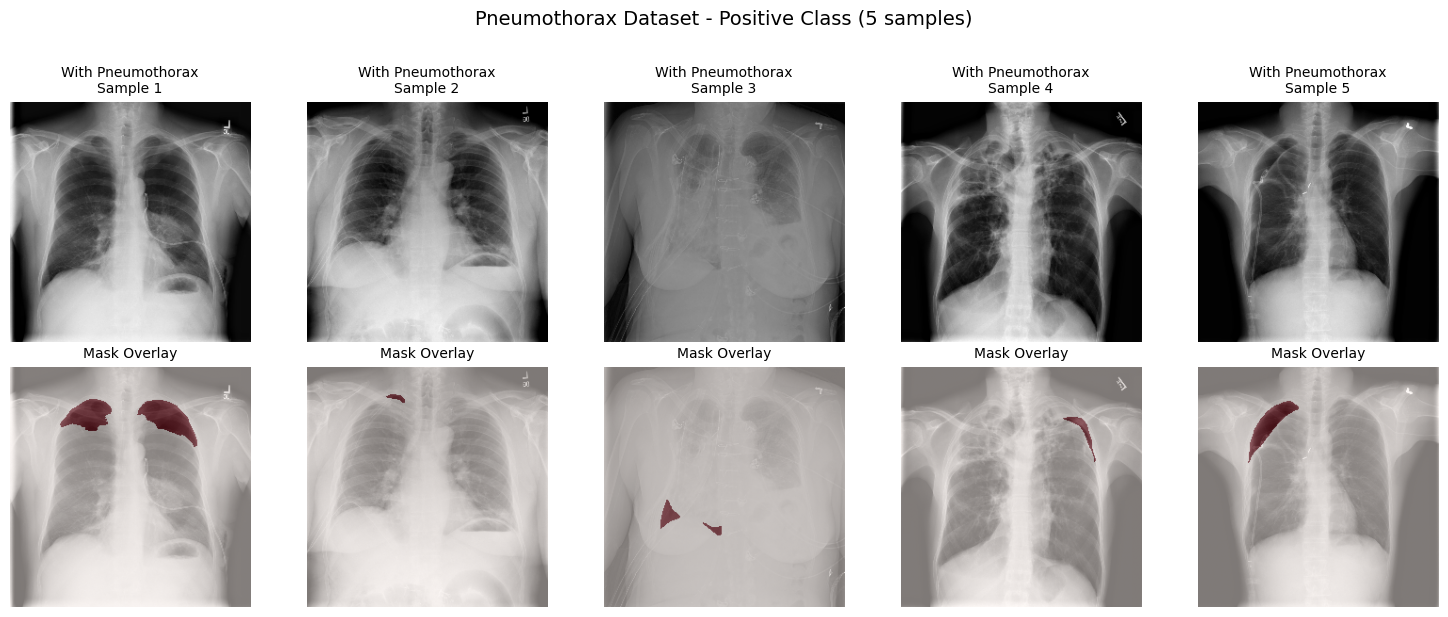

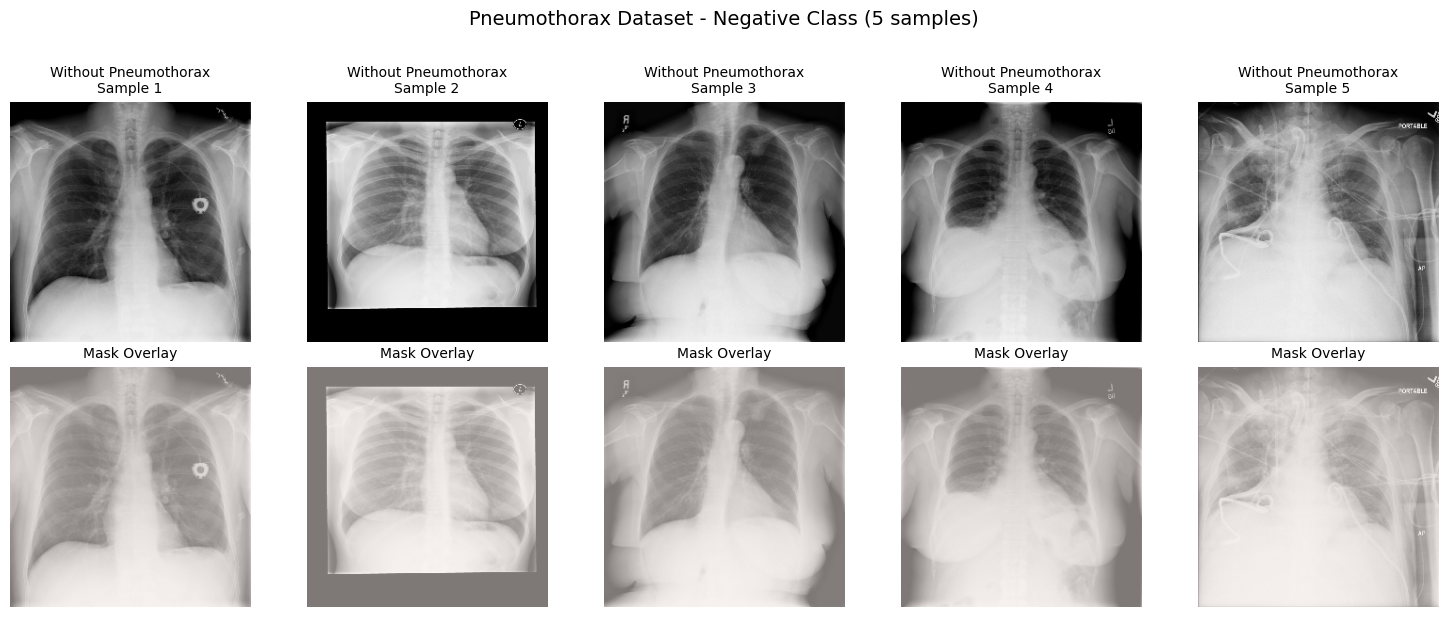

In [ ]:
# EDA: Visualize samples from all classes
def visualize_samples_by_class(dataset, df, has_pneumothorax, n_samples=5, title="Dataset Samples"):
    """
    Visualize n samples from each class (with and without pneumothorax).
    
    Args:
        dataset: Dataset object (should be created from df)
        df: DataFrame with filenames
        has_pneumothorax: Array indicating which samples have pneumothorax (aligned with df)
        n_samples: Number of samples to show per class
        title: Title for the plot
    """
    # Get indices for each class (these are indices into df, which match dataset indices)
    positive_indices = np.where(has_pneumothorax == 1)[0]
    negative_indices = np.where(has_pneumothorax == 0)[0]
    
    # Sample n_samples from each class
    np.random.seed(config.SEED)
    if len(positive_indices) >= n_samples:
        pos_samples = np.random.choice(positive_indices, n_samples, replace=False)
    else:
        pos_samples = positive_indices
    
    if len(negative_indices) >= n_samples:
        neg_samples = np.random.choice(negative_indices, n_samples, replace=False)
    else:
        neg_samples = negative_indices
    
    # Create figure: 2 rows (image/mask overlay) x n_samples columns for positive class
    fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 3, 6))
    if n_samples == 1:
        axes = axes.reshape(2, 1)
    
    # Plot positive class (with pneumothorax)
    for i, idx in enumerate(pos_samples):
        if idx < len(dataset):
            image, mask = dataset[idx]
            
            # Denormalize image
            img = image.permute(1, 2, 0).numpy()
            img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
            img = np.clip(img, 0, 1)
            
            mask_np = mask.squeeze().numpy()
            
            axes[0, i].imshow(img, cmap='gray')
            axes[0, i].set_title(f'With Pneumothorax\nSample {i+1}', fontsize=10)
            axes[0, i].axis('off')
            
            # Overlay mask on image
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].imshow(mask_np, alpha=0.5, cmap='Reds')
            axes[1, i].set_title(f'Mask Overlay', fontsize=10)
            axes[1, i].axis('off')
    
    plt.suptitle(f'{title} - Positive Class ({n_samples} samples)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Also show negative class samples
    fig2, axes2 = plt.subplots(2, n_samples, figsize=(n_samples * 3, 6))
    if n_samples == 1:
        axes2 = axes2.reshape(2, 1)
    
    for i, idx in enumerate(neg_samples):
        if idx < len(dataset):
            image, mask = dataset[idx]
            
            # Denormalize image
            img = image.permute(1, 2, 0).numpy()
            img = img * np.array([0.5, 0.5, 0.5]) + np.array([0.5, 0.5, 0.5])
            img = np.clip(img, 0, 1)
            
            mask_np = mask.squeeze().numpy()
            
            axes2[0, i].imshow(img, cmap='gray')
            axes2[0, i].set_title(f'Without Pneumothorax\nSample {i+1}', fontsize=10)
            axes2[0, i].axis('off')
            
            axes2[1, i].imshow(img, cmap='gray')
            axes2[1, i].imshow(mask_np, alpha=0.5, cmap='Reds')
            axes2[1, i].set_title(f'Mask Overlay', fontsize=10)
            axes2[1, i].axis('off')
    
    plt.suptitle(f'{title} - Negative Class ({n_samples} samples)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

# Create a dataset without augmentation for visualization (using train data)
eda_dataset = PneumothoraxDataset(
    df_train, images_dir, masks_dir, 
    get_validation_augmentation(),  # Use validation augmentation (no random transforms)
    config.PATCH_SIZE, is_training=False, use_patches=False
)

print("📊 Exploratory Data Analysis (Train Data)")
print(f"   Total samples: {len(df_train)}")
print(f"   With pneumothorax: {train_has_pneumothorax.sum()} ({100*train_has_pneumothorax.mean():.1f}%)")
print(f"   Without pneumothorax: {len(train_has_pneumothorax) - train_has_pneumothorax.sum()} ({100*(1-train_has_pneumothorax.mean()):.1f}%)")
print(f"\n   Showing {5} samples from each class...\n")

visualize_samples_by_class(eda_dataset, df_train, train_has_pneumothorax, n_samples=5, title="Pneumothorax Dataset")


In [ ]:
# Create train/val split and dataloaders
from torch.utils.data import WeightedRandomSampler

# Split train CSV into train (80%) and val (20%)
train_df, val_df = train_test_split(
    df_train, test_size=config.VAL_SPLIT, stratify=train_has_pneumothorax, random_state=config.SEED
)

# Use full test CSV as test set
test_df = df_test

# Create datasets
train_dataset = PneumothoraxDataset(train_df, images_dir, masks_dir, get_training_augmentation(config.PATCH_SIZE), 
                                     config.PATCH_SIZE, is_training=True, use_patches=config.USE_PATCHES)
val_dataset = PneumothoraxDataset(val_df, images_dir, masks_dir, get_validation_augmentation(), 
                                   config.PATCH_SIZE, is_training=False, use_patches=False)
test_dataset = PneumothoraxDataset(test_df, images_dir, masks_dir, get_validation_augmentation(), 
                                    config.PATCH_SIZE, is_training=False, use_patches=False)

# ⭐ KAGGLE TRICK #1: Class Rebalancing (ENABLED)
# Oversample positive cases for better learning on rare pneumothorax cases
# With gradient clipping + lower LR, this should be stable
USE_CLASS_REBALANCING = True

if USE_CLASS_REBALANCING:
    # Get pneumothorax labels for training set (after train/val split)
    train_indices_in_df_train = [df_train.index.get_loc(idx) for idx in train_df.index]
    train_split_has_pneumothorax = train_has_pneumothorax[train_indices_in_df_train]
    class_counts = np.bincount(train_split_has_pneumothorax.astype(int))
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[train_split_has_pneumothorax.astype(int)]
    
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, sampler=sampler,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    print(f"   ⭐ Class rebalancing enabled: Positive cases oversampled for ~50/50 balance")
else:
    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
                              num_workers=config.NUM_WORKERS, pin_memory=True, drop_last=True)
    print(f"   📊 Using standard shuffling (class rebalancing disabled for stability)")

val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                        num_workers=config.NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False, 
                         num_workers=config.NUM_WORKERS, pin_memory=True)

print(f"\n📂 Data split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
print(f"   Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


   ⭐ Class rebalancing enabled: Positive cases oversampled for ~50/50 balance

📂 Data split: Train=8539, Val=2135, Test=1372
   Train batches: 474, Val batches: 119, Test batches: 77


---
## 5. Model & Training Setup 🧠


In [ ]:
# Create UNet++ model (better than vanilla U-Net with nested skip connections)
# CHANGED: UnetPlusPlus has better feature fusion via nested/dense skip pathways
model = smp.UnetPlusPlus(
    encoder_name=config.ENCODER, 
    encoder_weights=config.ENCODER_WEIGHTS,
    in_channels=3, 
    classes=1, 
    activation=None, 
    decoder_attention_type=config.ATTENTION_TYPE,
    decoder_dropout=config.DECODER_DROPOUT if config.USE_DROPOUT else 0.0  # ⭐ SpatialDropout2D in decoder blocks
)
model = model.to(config.DEVICE)

# Training setup - Loss function selection
# Standard formulation: L = BCE/Focal + λ * Dice (BCE/Focal at full weight, Dice weighted by λ)
if config.LOSS_TYPE == 'focal_dice':
    criterion = DiceFocalLoss(
        dice_weight=config.DICE_WEIGHT,  # λ parameter
        focal_alpha=config.FOCAL_ALPHA,
        focal_gamma=config.FOCAL_GAMMA
    )
    loss_info = f"Focal + λ*Dice (λ={config.DICE_WEIGHT}, α={config.FOCAL_ALPHA}, γ={config.FOCAL_GAMMA})"
else:
    criterion = DiceBCELoss(dice_weight=config.DICE_WEIGHT)  # λ parameter
    loss_info = f"BCE + λ*Dice (λ={config.DICE_WEIGHT}, standard formulation)"

# CHANGED: AdamW with weight decay for better generalization
optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
# Keep ReduceLROnPlateau - adapts to validation performance
# FIXED: Increased patience for stability (was 3, now 5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, min_lr=1e-7)
scaler = GradScaler(enabled=config.MIXED_PRECISION)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🧠 Model: UNet++ with Attention ({config.ENCODER})")
print(f"   Parameters: {total_params:,}")
print(f"   Loss: {loss_info}")
print(f"   Dropout: {config.DECODER_DROPOUT if config.USE_DROPOUT else 'Disabled'} (decoder blocks)")
print(f"   Optimizer: AdamW (lr={config.LEARNING_RATE}, wd={config.WEIGHT_DECAY})")
print(f"   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5, min_lr=1e-7)")



🧠 Model: UNet++ with Attention (resnet34)
   Parameters: 26,281,332
   Loss: BCE + λ*Dice (λ=1.0, standard formulation)
   Dropout: 0.1 (decoder blocks)
   Optimizer: AdamW (lr=2e-05, wd=1e-05)
   Scheduler: ReduceLROnPlateau (factor=0.5, patience=5, min_lr=1e-7)


---
## 6. Training Loop 🚀

**Choose ONE of the following cells based on your config:**
- Cell 6A: Single Split Training (when `USE_KFOLD = False`)
- Cell 6B: K-Fold Cross-Validation (when `USE_KFOLD = True`)

### 6A. Single Split Training (Default - Faster)


In [ ]:
# ⚠️ RUN THIS CELL ONLY IF USE_KFOLD = False
if config.USE_KFOLD:
    print("⚠️ USE_KFOLD is True - Skip this cell and run Section 6B instead!")
    best_dice = 0.0  # Placeholder
    best_iou = 0.0
    history = {}
    best_model_path = ""
else:
    # Training history
    history = {
        'train_loss': [], 'train_dice': [], 'train_f1': [],
        'val_loss': [], 'val_dice': [], 'val_iou': [], 'val_f1': []
    }
    best_dice = 0.0
    best_iou = 0.0
    patience_counter = 0
    best_model_path = None  # Will be set when saving

    print("=" * 60)
    print("🚀 STARTING SINGLE-SPLIT TRAINING")
    print("=" * 60)
    
    for epoch in range(config.EPOCHS):
        # === TRAINING ===
        model.train()
        train_loss, train_dice, train_f1 = 0.0, 0.0, 0.0
        optimizer.zero_grad()
        
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{config.EPOCHS}")
        for batch_idx, (images, masks) in pbar:
            images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
            
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images)
                loss = criterion(outputs, masks) / config.GRADIENT_ACCUMULATION
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % config.GRADIENT_ACCUMULATION == 0:
                # ⭐ Gradient clipping for stability (especially with class rebalancing)
                scaler.unscale_(optimizer)  # Unscale gradients before clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            train_loss += loss.item() * config.GRADIENT_ACCUMULATION * images.size(0)
            train_dice += dice_coefficient(outputs, masks).item() * images.size(0)
            train_f1 += f1_score(outputs, masks).item() * images.size(0)
            pbar.set_postfix({'loss': f'{loss.item()*config.GRADIENT_ACCUMULATION:.4f}'})
        
        train_loss /= len(train_loader.dataset)
        train_dice /= len(train_loader.dataset)
        train_f1 /= len(train_loader.dataset)
        
        # === VALIDATION ===
        model.eval()
        val_loss, val_dice, val_iou, val_f1 = 0.0, 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                with autocast(enabled=config.MIXED_PRECISION):
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)
                val_dice += dice_coefficient(outputs, masks).item() * images.size(0)
                val_iou += iou_score(outputs, masks).item() * images.size(0)
                val_f1 += f1_score(outputs, masks).item() * images.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_dice /= len(val_loader.dataset)
        val_iou /= len(val_loader.dataset)
        val_f1 /= len(val_loader.dataset)
        
        scheduler.step(val_dice)  # FIXED: ReduceLROnPlateau needs the metric value
        # scheduler.step()
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_dice'].append(train_dice)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)
        history['val_iou'].append(val_iou)
        history['val_f1'].append(val_f1)
        
        print(f"\n📊 Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Dice={train_dice:.4f}, Train F1={train_f1:.4f}")
        print(f"   Val Loss={val_loss:.4f}, Val Dice={val_dice:.4f}, Val IoU={val_iou:.4f}, Val F1={val_f1:.4f}")
        
        # Save best model with metrics in filename
        if val_dice > best_dice:
            best_dice = val_dice
            best_iou = val_iou
            patience_counter = 0
            # Create descriptive filename: pneumo_dice{D}_iou{I}_ep{E}.pth
            model_name = f"pneumo_dice{val_dice:.4f}_iou{val_iou:.4f}_ep{epoch+1}.pth"
            best_model_path = os.path.join(config.OUTPUT_DIR, model_name)
            torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 
                        'val_dice': val_dice, 'val_iou': val_iou, 'history': history,
                        'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE}, best_model_path)
            print(f"   ✅ New best model saved: {model_name}")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{config.PATIENCE})")
        
        if patience_counter >= config.PATIENCE:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break

    print("\n" + "=" * 60)
    print(f"🎉 TRAINING COMPLETE! Best Dice: {best_dice:.4f}")
    print("=" * 60)


🚀 STARTING SINGLE-SPLIT TRAINING


Epoch 1/30:   0%|          | 0/474 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 144.00 MiB. GPU 0 has a total capacity of 7.62 GiB of which 92.12 MiB is free. Process 87079 has 3.70 GiB memory in use. Including non-PyTorch memory, this process has 3.39 GiB memory in use. Of the allocated memory 3.04 GiB is allocated by PyTorch, and 240.25 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### 6B. K-Fold Cross-Validation (Optional - More Robust)

⚠️ **Run this cell ONLY if `USE_KFOLD = True` in config**


In [ ]:
# ⚠️ RUN THIS CELL ONLY IF USE_KFOLD = True
if not config.USE_KFOLD:
    print("⚠️ USE_KFOLD is False - Skip this cell, you already ran 6A!")
    fold_results = []
else:
    print("=" * 60)
    print(f"🚀 STARTING {config.N_FOLDS}-FOLD CROSS-VALIDATION")
    print("=" * 60)
    
    kfold = StratifiedKFold(n_splits=config.N_FOLDS, shuffle=True, random_state=config.SEED)
    fold_results = []
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_train, train_has_pneumothorax)):
        print(f"\n{'='*60}")
        print(f"📁 FOLD {fold+1}/{config.N_FOLDS}")
        print(f"{'='*60}")
        
        # Split data
        fold_train_df = df_train.iloc[train_idx]
        fold_val_df = df_train.iloc[val_idx]
        print(f"   Train: {len(fold_train_df)}, Val: {len(fold_val_df)}")
        
        # Create datasets
        fold_train_dataset = PneumothoraxDataset(
            fold_train_df, images_dir, masks_dir, 
            get_training_augmentation(config.PATCH_SIZE),
            config.PATCH_SIZE, is_training=True, use_patches=config.USE_PATCHES
        )
        fold_val_dataset = PneumothoraxDataset(
            fold_val_df, images_dir, masks_dir,
            get_validation_augmentation(),
            config.PATCH_SIZE, is_training=False, use_patches=False
        )
        
        fold_train_loader = DataLoader(fold_train_dataset, batch_size=config.BATCH_SIZE,
                                       shuffle=True, num_workers=config.NUM_WORKERS, 
                                       pin_memory=True, drop_last=True)
        fold_val_loader = DataLoader(fold_val_dataset, batch_size=config.BATCH_SIZE,
                                     shuffle=False, num_workers=config.NUM_WORKERS, pin_memory=True)
        
        # Fresh model for each fold - UNet++ with nested skip connections
        fold_model = smp.UnetPlusPlus(
            encoder_name=config.ENCODER, 
            encoder_weights=config.ENCODER_WEIGHTS,
            in_channels=3, 
            classes=1, 
            activation=None, 
            decoder_attention_type=config.ATTENTION_TYPE,
            decoder_dropout=config.DECODER_DROPOUT if config.USE_DROPOUT else 0.0  # SpatialDropout2D in decoder blocks
        ).to(config.DEVICE)
        
        # CHANGED: AdamW + ReduceLROnPlateau
        fold_optimizer = torch.optim.AdamW(fold_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
        fold_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(fold_optimizer, mode='max', factor=0.5, patience=3)
        fold_scaler = GradScaler(enabled=config.MIXED_PRECISION)
        
        fold_history = {'train_loss': [], 'train_dice': [], 'val_loss': [], 'val_dice': [], 'val_iou': []}
        fold_best_dice = 0.0
        fold_best_iou = 0.0
        fold_patience = 0
        fold_model_path = None  # Will be set when saving
        
        for epoch in range(config.EPOCHS):
            # Training
            fold_model.train()
            train_loss, train_dice = 0.0, 0.0
            fold_optimizer.zero_grad()
            
            pbar = tqdm(enumerate(fold_train_loader), total=len(fold_train_loader), 
                       desc=f"Fold {fold+1} Epoch {epoch+1}", leave=False)
            for batch_idx, (images, masks) in pbar:
                images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                with autocast(enabled=config.MIXED_PRECISION):
                    outputs = fold_model(images)
                    loss = criterion(outputs, masks) / config.GRADIENT_ACCUMULATION
                fold_scaler.scale(loss).backward()
                if (batch_idx + 1) % config.GRADIENT_ACCUMULATION == 0:
                    fold_scaler.step(fold_optimizer)
                    fold_scaler.update()
                    fold_optimizer.zero_grad()
                train_loss += loss.item() * config.GRADIENT_ACCUMULATION * images.size(0)
                train_dice += dice_coefficient(outputs, masks).item() * images.size(0)
            
            train_loss /= len(fold_train_loader.dataset)
            train_dice /= len(fold_train_loader.dataset)
            
            # Validation
            fold_model.eval()
            val_loss, val_dice, val_iou = 0.0, 0.0, 0.0
            with torch.no_grad():
                for images, masks in fold_val_loader:
                    images, masks = images.to(config.DEVICE), masks.to(config.DEVICE)
                    with autocast(enabled=config.MIXED_PRECISION):
                        outputs = fold_model(images)
                        loss = criterion(outputs, masks)
                    val_loss += loss.item() * images.size(0)
                    val_dice += dice_coefficient(outputs, masks).item() * images.size(0)
                    val_iou += iou_score(outputs, masks).item() * images.size(0)
            
            val_loss /= len(fold_val_loader.dataset)
            val_dice /= len(fold_val_loader.dataset)
            val_iou /= len(fold_val_loader.dataset)
            
            fold_scheduler.step(val_dice)  # FIXED: ReduceLROnPlateau needs the metric value
            # fold_scheduler.step()
            fold_history['train_loss'].append(train_loss)
            fold_history['train_dice'].append(train_dice)
            fold_history['val_loss'].append(val_loss)
            fold_history['val_dice'].append(val_dice)
            fold_history['val_iou'].append(val_iou)
            
            # Save best model with metrics in filename
            if val_dice > fold_best_dice:
                fold_best_dice = val_dice
                fold_best_iou = val_iou
                fold_patience = 0
                # Create descriptive filename: pneumo_fold{F}_dice{D}_iou{I}_ep{E}.pth
                model_name = f"pneumo_fold{fold}_dice{val_dice:.4f}_iou{val_iou:.4f}_ep{epoch+1}.pth"
                fold_model_path = os.path.join(config.OUTPUT_DIR, model_name)
                torch.save({'fold': fold, 'epoch': epoch, 'model_state_dict': fold_model.state_dict(),
                           'val_dice': val_dice, 'val_iou': val_iou, 'history': fold_history,
                           'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE}, fold_model_path)
            else:
                fold_patience += 1
            
            if fold_patience >= config.PATIENCE:
                print(f"   Early stopping at epoch {epoch+1}")
                break
        
        fold_results.append({'fold': fold, 'best_dice': fold_best_dice, 'best_iou': fold_best_iou, 
                             'history': fold_history, 'model_path': fold_model_path})
        print(f"   ✅ Fold {fold+1} Best Dice: {fold_best_dice:.4f}, IoU: {fold_best_iou:.4f}")
    
    # Summary
    fold_dices = [r['best_dice'] for r in fold_results]
    fold_ious = [r['best_iou'] for r in fold_results]
    best_fold_idx = np.argmax(fold_dices)
    best_dice = np.mean(fold_dices)
    best_iou = np.mean(fold_ious)
    history = fold_results[best_fold_idx]['history']  # Use best fold's history for plotting
    best_model_path = fold_results[best_fold_idx]['model_path']  # Best fold's model path
    
    print("\n" + "=" * 60)
    print("📊 K-FOLD CROSS-VALIDATION RESULTS")
    print("=" * 60)
    for i, (d, iou) in enumerate(zip(fold_dices, fold_ious)):
        print(f"   Fold {i+1}: Dice = {d:.4f}, IoU = {iou:.4f}")
    print("-" * 40)
    print(f"   Mean Dice: {np.mean(fold_dices):.4f} ± {np.std(fold_dices):.4f}")
    print(f"   Mean IoU:  {np.mean(fold_ious):.4f} ± {np.std(fold_ious):.4f}")
    print(f"   Best Fold: {best_fold_idx+1} (Dice: {max(fold_dices):.4f})")
    print("=" * 60)


⚠️ USE_KFOLD is False - Skip this cell, you already ran 6A!


---
## 7. Kaggle Tricks: Optimal Threshold & TTA 🎯

⭐ **Post-Training Enhancements** to boost performance


In [ ]:
# ⭐ KAGGLE TRICK #2: Find Optimal Threshold
# Don't just use 0.5! Find the threshold that maximizes Dice on validation set

def find_optimal_threshold(model, val_loader, device, search_range=(0.3, 0.7, 0.05)):
    """
    Find threshold that maximizes Dice coefficient on validation set.
    
    ⚠️ MEMORY-EFFICIENT VERSION: Processes predictions in batches instead of storing all.
    This prevents OOM crashes on systems with limited RAM.
    """
    model.eval()
    
    best_threshold = 0.5
    best_dice = 0.0
    
    print(f"🎯 Searching for optimal threshold in range {search_range[0]:.2f}-{search_range[1]:.2f}...")
    print("   (Memory-efficient: processing in batches)\n")
    thresholds = np.arange(search_range[0], search_range[1], search_range[2])
    
    # Evaluate each threshold by iterating through validation set
    for threshold in thresholds:
        total_dice = 0.0
        num_batches = 0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                # Get predictions
                outputs = torch.sigmoid(model(images))
                pred_binary = (outputs > threshold).float()
                
                # Calculate Dice for this batch
                batch_dice = dice_coefficient(pred_binary, masks, threshold=0.5).item()
                total_dice += batch_dice
                num_batches += 1
        
        # Average Dice across all batches
        dice = total_dice / num_batches if num_batches > 0 else 0.0
        
        if dice > best_dice:
            best_dice = dice
            best_threshold = threshold
        print(f"   Threshold {threshold:.2f}: Dice = {dice:.4f}")
    
    # Calculate baseline Dice at 0.5 for comparison
    baseline_dice = 0.0
    num_batches = 0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = torch.sigmoid(model(images))
            pred_binary = (outputs > 0.5).float()
            batch_dice = dice_coefficient(pred_binary, masks, threshold=0.5).item()
            baseline_dice += batch_dice
            num_batches += 1
    baseline_dice = baseline_dice / num_batches if num_batches > 0 else 0.0
    
    print(f"\n✅ Optimal threshold: {best_threshold:.2f}")
    print(f"   Dice improvement: {best_dice:.4f} (vs {baseline_dice:.4f} at 0.5)")
    return best_threshold, best_dice
    
# Find optimal threshold if training completed
if 'best_model_path' in locals() and best_model_path and os.path.exists(best_model_path):
    optimal_threshold, optimal_dice = find_optimal_threshold(model, val_loader, config.DEVICE)
else:
    optimal_threshold = 0.5
    print("⚠️ No trained model found, using default threshold=0.5")


🎯 Searching for optimal threshold in range 0.30-0.70...
   (Memory-efficient: processing in batches)

   Threshold 0.30: Dice = 0.7681
   Threshold 0.35: Dice = 0.7692
   Threshold 0.40: Dice = 0.7693
   Threshold 0.45: Dice = 0.7699
   Threshold 0.50: Dice = 0.7705
   Threshold 0.55: Dice = 0.7707
   Threshold 0.60: Dice = 0.7703
   Threshold 0.65: Dice = 0.7700

✅ Optimal threshold: 0.55
   Dice improvement: 0.7707 (vs 0.7705 at 0.5)


In [ ]:
# ⭐ KAGGLE TRICK #3: Test-Time Augmentation (TTA)
# Apply horizontal flip during inference and average predictions

def predict_with_tta(model, image, device, threshold=0.5):
    """
    Apply Test-Time Augmentation for more robust predictions.
    
    For chest X-rays, we only flip horizontally (not vertically).
    Pneumothorax can occur on either side, so horizontal flip is valid.
    """
    model.eval()
    with torch.no_grad():
        # Original prediction
        pred1 = torch.sigmoid(model(image.unsqueeze(0).to(device)))
        
        # Horizontal flip prediction
        image_hflip = torch.flip(image, [2])  # flip width dimension
        pred2 = torch.sigmoid(model(image_hflip.unsqueeze(0).to(device)))
        pred2 = torch.flip(pred2, [3])  # flip prediction back
        
        # Average predictions
        pred_avg = (pred1 + pred2) / 2
    
    # Apply threshold
    pred_binary = (pred_avg > threshold).float()
    return pred_avg.squeeze().cpu().numpy(), pred_binary.squeeze().cpu().numpy()

print("✅ TTA function defined")


✅ TTA function defined


---
## 8. Training Curves 📈


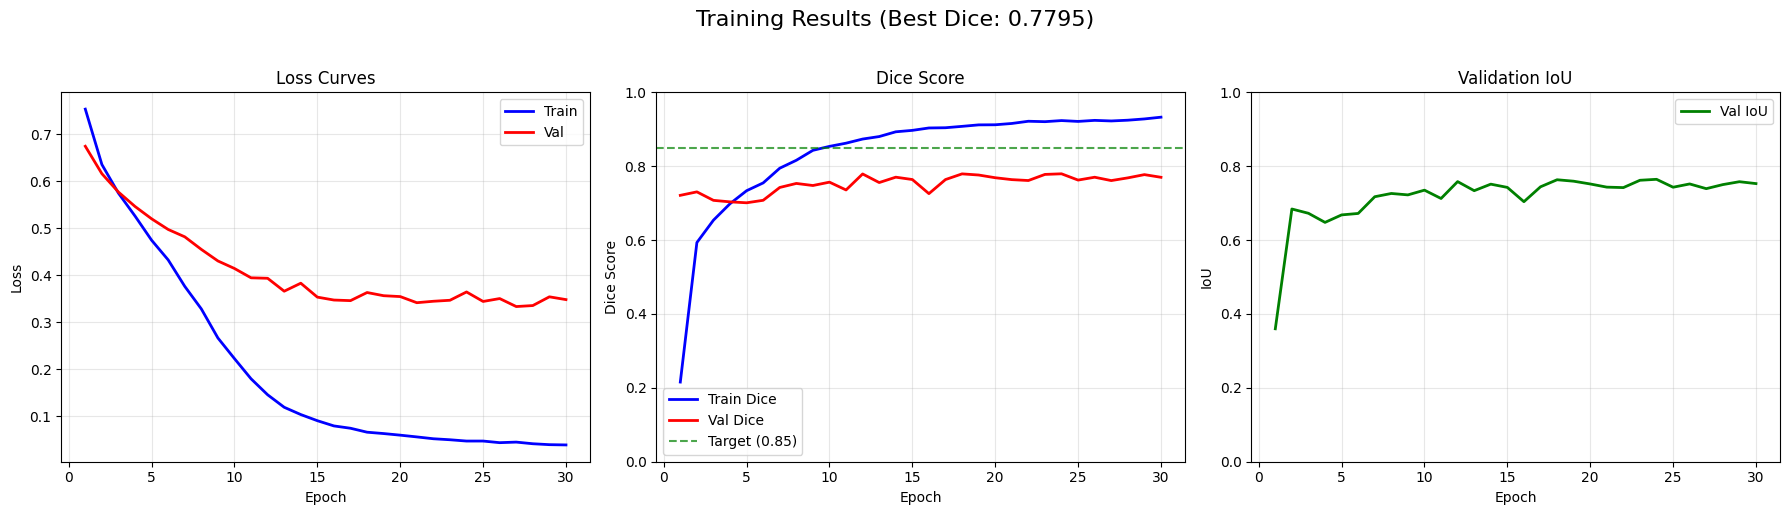

In [ ]:
if history and len(history.get('train_loss', [])) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss'); axes[0].set_title('Loss Curves')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['train_dice'], 'b-', label='Train Dice', linewidth=2)
    axes[1].plot(epochs, history['val_dice'], 'r-', label='Val Dice', linewidth=2)
    axes[1].axhline(y=0.85, color='green', linestyle='--', label='Target (0.85)', alpha=0.7)
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Dice Score'); axes[1].set_title('Dice Score')
    axes[1].legend(); axes[1].grid(True, alpha=0.3); axes[1].set_ylim(0, 1)

    axes[2].plot(epochs, history['val_iou'], 'g-', label='Val IoU', linewidth=2)
    axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('IoU'); axes[2].set_title('Validation IoU')
    axes[2].legend(); axes[2].grid(True, alpha=0.3); axes[2].set_ylim(0, 1)

    title = f'Training Results (Best Dice: {best_dice:.4f})' if not config.USE_KFOLD else f'Best Fold Results (Dice: {max([r["best_dice"] for r in fold_results]):.4f})'
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("⚠️ No training history to plot")


---
## 8.5. Comprehensive Evaluation on Dev/Test Sets 📊

Evaluate the trained model with **all metrics** (Dice, IoU, F1, Precision, Recall, Accuracy)


In [ ]:
def comprehensive_evaluate(model, data_loader, device, split_name="Evaluation", threshold=0.5):
    """
    Comprehensive evaluation with all metrics: Dice, IoU, F1, Precision, Recall, Accuracy.
    
    Args:
        model: Trained model
        data_loader: DataLoader for the dataset to evaluate
        device: Device to run evaluation on
        split_name: Name of the split (e.g., "Validation", "Test")
        threshold: Threshold for binary predictions
    
    Returns:
        Dictionary with all metrics
    """
    model.eval()
    all_metrics = {
        'loss': 0.0,
        'dice': 0.0,
        'iou': 0.0,
        'f1': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'accuracy': 0.0
    }
    
    total_samples = 0
    
    print(f"\n{'='*60}")
    print(f"📊 {split_name.upper()} EVALUATION")
    print(f"{'='*60}")
    
    with torch.no_grad():
        pbar = tqdm(data_loader, desc=f"Evaluating {split_name}")
        for images, masks in pbar:
            images, masks = images.to(device), masks.to(device)
            
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images)
                loss = criterion(outputs, masks)
            
            batch_size = images.size(0)
            total_samples += batch_size
            
            # Calculate all metrics
            all_metrics['loss'] += loss.item() * batch_size
            all_metrics['dice'] += dice_coefficient(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['iou'] += iou_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['f1'] += f1_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['precision'] += precision_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['recall'] += recall_score(outputs, masks, threshold=threshold).item() * batch_size
            all_metrics['accuracy'] += accuracy_score(outputs, masks, threshold=threshold).item() * batch_size
    
    # Average over all samples
    for key in all_metrics:
        all_metrics[key] /= total_samples
    
    # Print results
    print(f"\n📈 Results (threshold={threshold}):")
    print(f"   Loss:      {all_metrics['loss']:.4f}")
    print(f"   Dice:      {all_metrics['dice']:.4f}")
    print(f"   IoU:       {all_metrics['iou']:.4f}")
    print(f"   F1 Score:  {all_metrics['f1']:.4f}")
    print(f"   Precision: {all_metrics['precision']:.4f}")
    print(f"   Recall:    {all_metrics['recall']:.4f}")
    print(f"   Accuracy:  {all_metrics['accuracy']:.4f}")
    print(f"{'='*60}\n")
    
    return all_metrics

# Evaluate on validation set
if 'best_model_path' in locals() and best_model_path and os.path.exists(best_model_path):
    print("🔍 Loading best model for evaluation...")
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Use optimal threshold if available, otherwise use 0.5
    eval_threshold = optimal_threshold if 'optimal_threshold' in locals() else 0.5
    
    # Evaluate on validation set (used during training)
    val_metrics = comprehensive_evaluate(model, val_loader, config.DEVICE, 
                                         split_name="Validation", threshold=eval_threshold)
    
    # Evaluate on test set (held-out, final evaluation)
    if 'test_loader' in locals() and test_loader is not None:
        print("\n" + "="*60)
        print("🎯 FINAL EVALUATION ON HELD-OUT TEST SET")
        print("="*60)
        test_metrics = comprehensive_evaluate(model, test_loader, config.DEVICE,
                                             split_name="Test (Final)", threshold=eval_threshold)
    else:
        print("⚠️ No test set available. Using validation set for final evaluation.")
else:
    print("⚠️ No trained model found. Run training cells first!")


🔍 Loading best model for evaluation...

📊 VALIDATION EVALUATION


Evaluating Validation:   0%|          | 0/134 [00:00<?, ?it/s]


📈 Results (threshold=0.5499999999999999):
   Loss:      0.3644
   Dice:      0.7799
   IoU:       0.7647
   F1 Score:  0.7799
   Precision: 0.9033
   Recall:    0.8223
   Accuracy:  0.9972



---
## 9. Visualize Predictions with TTA 🎯

Using **optimal threshold** and **Test-Time Augmentation** for best results


✅ Loaded best model: pneumo_dice0.7795_iou0.7645_ep24.pth
   Dice: 0.7795, IoU: 0.7645310207608154

🎯 Using threshold: 0.55 for predictions


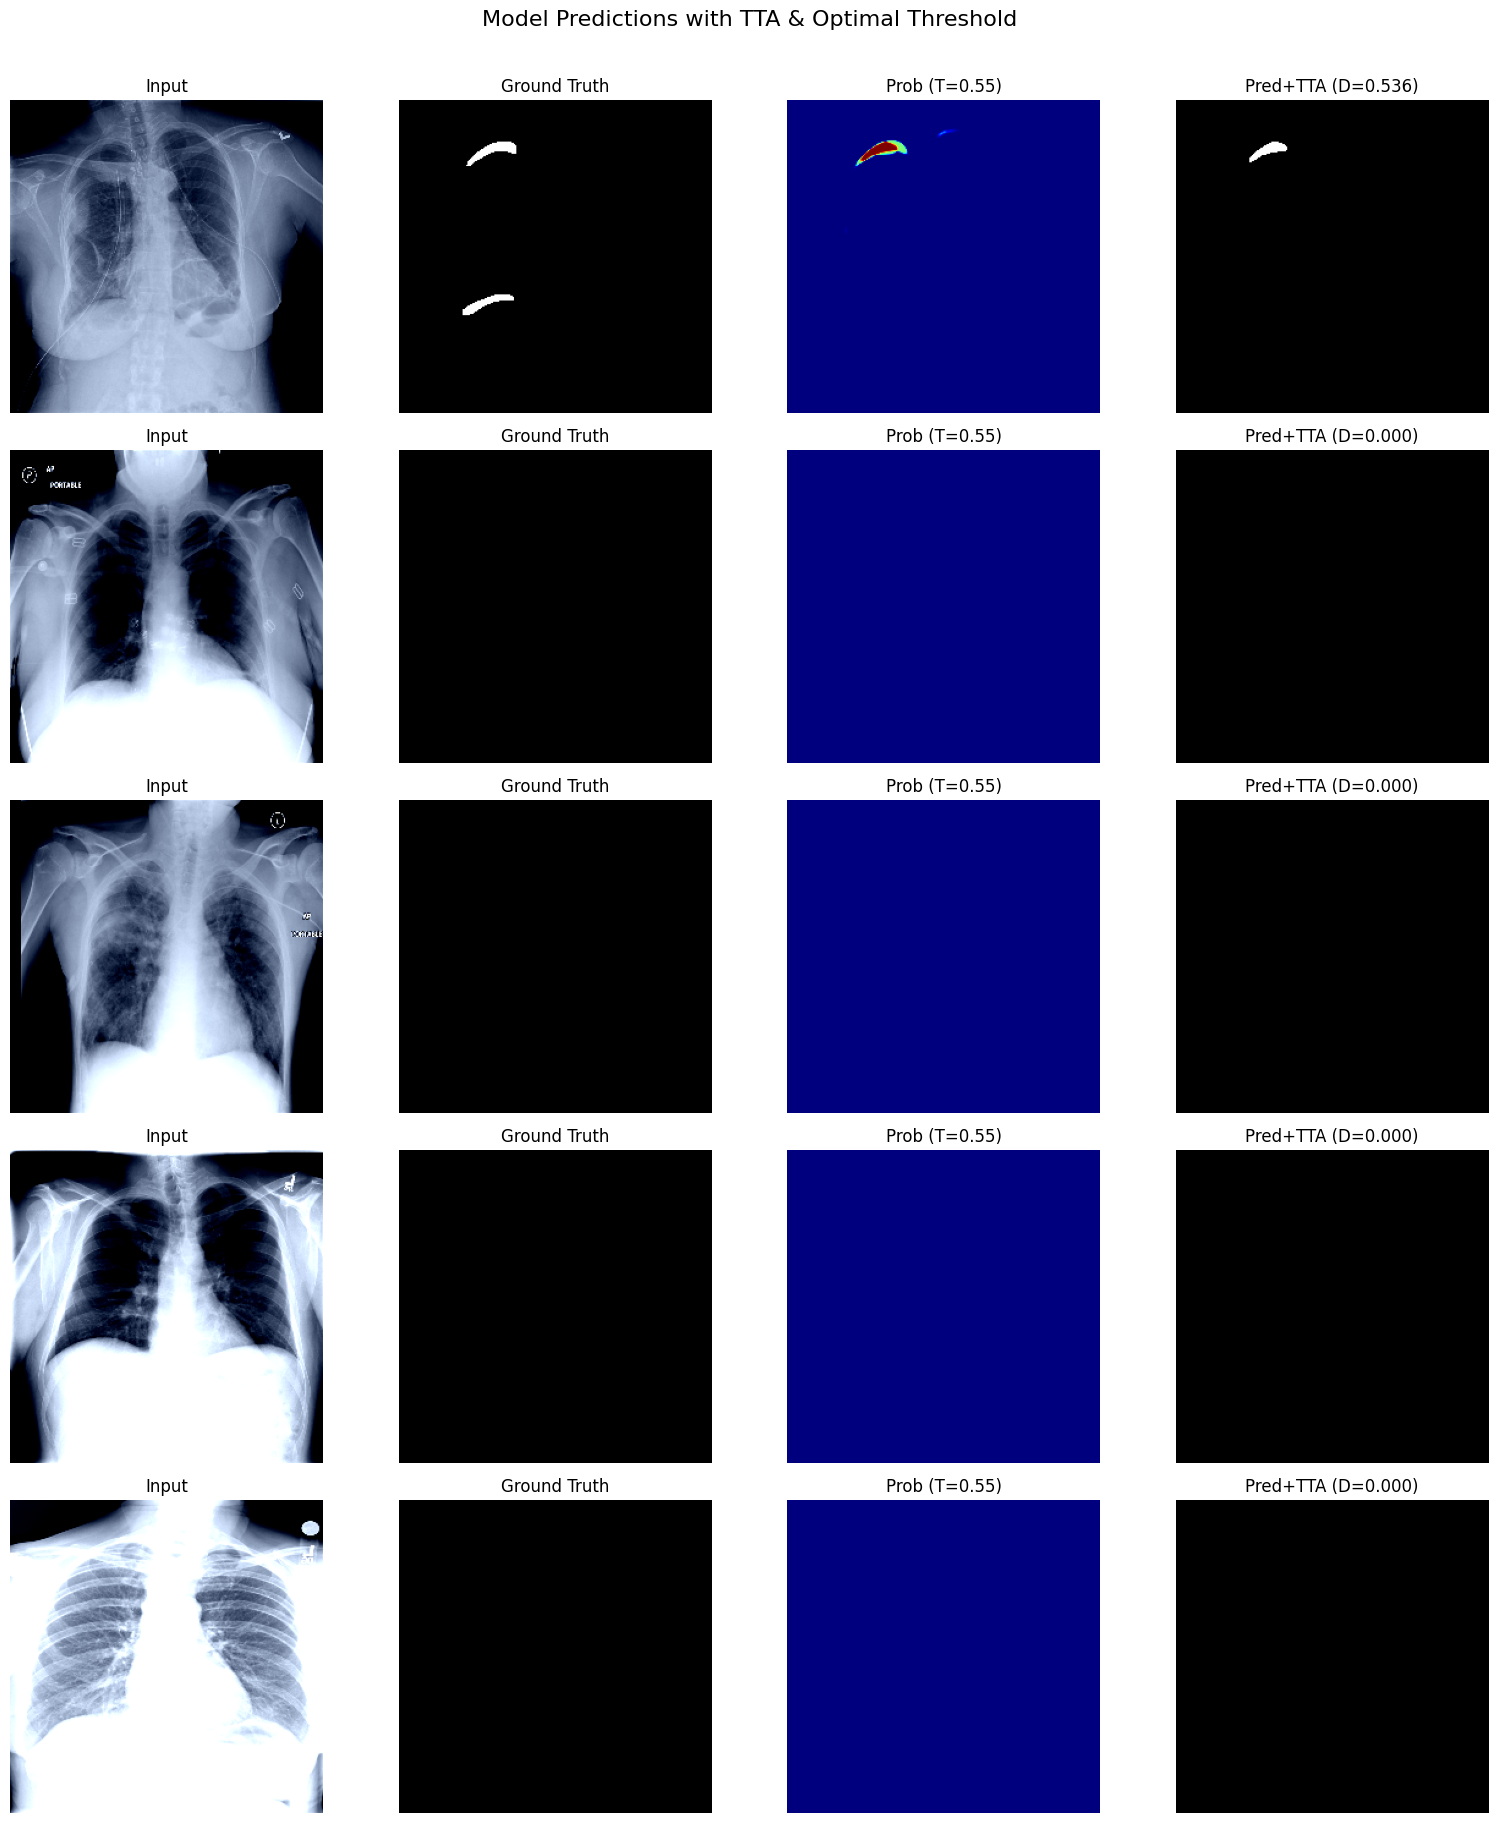

In [ ]:
# Load best model
if best_model_path and os.path.exists(best_model_path):
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✅ Loaded best model: {os.path.basename(best_model_path)}")
    print(f"   Dice: {checkpoint['val_dice']:.4f}, IoU: {checkpoint.get('val_iou', 'N/A')}")
else:
    print("⚠️ No model checkpoint found - skipping predictions")

# Visualize predictions with TTA and optimal threshold
# CORRECT: Use same normalization as training (0.5, 0.5, 0.5) for grayscale
GRAYSCALE_MEAN = np.array([0.5, 0.5, 0.5])
GRAYSCALE_STD = np.array([0.5, 0.5, 0.5])

# Use optimal threshold if found, otherwise default to 0.5
threshold = optimal_threshold if 'optimal_threshold' in locals() else 0.5
print(f"\n🎯 Using threshold: {threshold:.2f} for predictions")

# Get samples from each class (5 with pneumothorax, 5 without)
# Get validation set labels
# Get validation set labels from train_has_pneumothorax
if 'val_df' in locals() and 'train_has_pneumothorax' in locals():
    val_indices_in_df_train = [df_train.index.get_loc(idx) for idx in val_df.index]
    val_has_pneumothorax = train_has_pneumothorax[val_indices_in_df_train]
else:
    val_has_pneumothorax = None

if val_has_pneumothorax is not None:
    positive_indices = np.where(val_has_pneumothorax == 1)[0]
    negative_indices = np.where(val_has_pneumothorax == 0)[0]
    
    np.random.seed(config.SEED)
    n_per_class = 5
    
    # Sample 5 from each class
    if len(positive_indices) >= n_per_class:
        pos_samples = np.random.choice(positive_indices, n_per_class, replace=False)
    else:
        pos_samples = positive_indices
    
    if len(negative_indices) >= n_per_class:
        neg_samples = np.random.choice(negative_indices, n_per_class, replace=False)
    else:
        neg_samples = negative_indices
    
    all_indices = list(pos_samples) + list(neg_samples)
    all_labels = ['With Pneumothorax'] * len(pos_samples) + ['Without Pneumothorax'] * len(neg_samples)
else:
    # Fallback: random sampling if labels not available
    n_per_class = 5
    np.random.seed(config.SEED)
    all_indices = np.random.choice(len(val_dataset), min(n_per_class * 2, len(val_dataset)), replace=False)
    all_labels = ['Sample'] * len(all_indices)

# Create figure: 10 rows (5 positive + 5 negative) x 6 columns
# Columns: Input, Ground Truth, Input+GT Overlay, Prob Map, Pred Mask, Input+Pred Overlay
fig, axes = plt.subplots(len(all_indices), 6, figsize=(24, len(all_indices) * 2))
if len(all_indices) == 1:
    axes = axes.reshape(1, 6)

for row, (idx, label) in enumerate(zip(all_indices, all_labels)):
    if idx < len(val_dataset):
        image, mask = val_dataset[idx]
        
        # ⭐ Use TTA for more robust predictions
        if 'predict_with_tta' in globals():
            pred_prob, pred_binary = predict_with_tta(model, image, config.DEVICE, threshold=threshold)
        else:
            # Fallback to standard prediction
            with torch.no_grad():
                pred = model(image.unsqueeze(0).to(config.DEVICE))
                pred_prob = torch.sigmoid(pred).squeeze().cpu().numpy()
                pred_binary = (pred_prob > threshold).astype(float)
        
        img = image.permute(1, 2, 0).numpy()
        # Denormalize using same stats as training
        img = img * GRAYSCALE_STD + GRAYSCALE_MEAN
        img = np.clip(img, 0, 1)
        mask_np = mask.squeeze().numpy()
        
        intersection = (pred_binary * mask_np).sum()
        sample_dice = 2 * intersection / (pred_binary.sum() + mask_np.sum() + 1e-6)
        
        # Column 1: Input
        axes[row, 0].imshow(img, cmap='gray')
        axes[row, 0].set_title(f'{label}\nInput', fontsize=10)
        axes[row, 0].axis('off')
        
        # Column 2: Ground Truth mask
        axes[row, 1].imshow(mask_np, cmap='gray')
        axes[row, 1].set_title('Ground Truth', fontsize=10)
        axes[row, 1].axis('off')
        
        # Column 3: Input + Ground Truth overlay (translucent)
        axes[row, 2].imshow(img, cmap='gray')
        axes[row, 2].imshow(mask_np, alpha=0.5, cmap='Reds')
        axes[row, 2].set_title('Input + GT Overlay', fontsize=10)
        axes[row, 2].axis('off')
        
        # Column 4: Probability map
        axes[row, 3].imshow(pred_prob, cmap='jet', vmin=0, vmax=1)
        axes[row, 3].set_title(f'Prob Map (T={threshold:.2f})', fontsize=10)
        axes[row, 3].axis('off')
        
        # Column 5: Predicted mask
        axes[row, 4].imshow(pred_binary, cmap='gray')
        axes[row, 4].set_title(f'Pred Mask\nDice={sample_dice:.3f}', fontsize=10)
        axes[row, 4].axis('off')
        
        # Column 6: Input + Predicted mask overlay (translucent)
        axes[row, 5].imshow(img, cmap='gray')
        axes[row, 5].imshow(pred_binary, alpha=0.5, cmap='Blues')
        axes[row, 5].set_title('Input + Pred Overlay', fontsize=10)
        axes[row, 5].axis('off')

title_suffix = f'({n_per_class} samples per class)' if val_has_pneumothorax is not None else ''
plt.suptitle(f'Model Predictions with TTA & Optimal Threshold {title_suffix}', fontsize=16, y=0.998)
plt.tight_layout()
plt.savefig(os.path.join(config.OUTPUT_DIR, 'predictions_tta.png'), dpi=150, bbox_inches='tight')
plt.show()


---
## 10. Save Results 💾


In [ ]:
import json

# Build summary based on training mode
if config.USE_KFOLD and len(fold_results) > 0:
    fold_dices = [r['best_dice'] for r in fold_results]
    summary = {
        'mode': 'kfold',
        'n_folds': config.N_FOLDS,
        'mean_dice': float(np.mean(fold_dices)),
        'std_dice': float(np.std(fold_dices)),
        'fold_dices': [float(d) for d in fold_dices],
        'best_fold': int(np.argmax(fold_dices)),
        'config': {'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE,
                   'batch_size': config.BATCH_SIZE, 'learning_rate': config.LEARNING_RATE}
    }
    final_dice = np.mean(fold_dices)
    final_iou = np.mean([max(r['history']['val_iou']) for r in fold_results])
else:
    summary = {
        'mode': 'single_split',
        'best_dice': float(best_dice),
        'best_iou': float(max(history['val_iou'])) if history else 0,
        'epochs_trained': len(history['train_loss']) if history else 0,
        'config': {'encoder': config.ENCODER, 'patch_size': config.PATCH_SIZE, 
                   'batch_size': config.BATCH_SIZE, 'learning_rate': config.LEARNING_RATE},
        'history': {k: [float(x) for x in v] for k, v in history.items()} if history else {}
    }
    final_dice = best_dice
    final_iou = max(history['val_iou']) if history and 'val_iou' in history else 0

with open(os.path.join(config.OUTPUT_DIR, 'training_summary.json'), 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✅ Results saved to {config.OUTPUT_DIR}/")
if best_model_path:
    print(f"   - {os.path.basename(best_model_path)}")
print(f"   - training_curves.png")
print(f"   - predictions.png")
print(f"   - training_summary.json")

print("\n" + "=" * 60)
print("📊 FINAL SUMMARY")
print("=" * 60)
if config.USE_KFOLD and len(fold_results) > 0:
    print(f"🔄 Mode: {config.N_FOLDS}-Fold Cross-Validation")
    print(f"🏆 Mean Dice: {np.mean(fold_dices):.4f} ± {np.std(fold_dices):.4f}")
else:
    print(f"🔄 Mode: Single Split")
    print(f"🏆 Best Dice: {final_dice:.4f}")
    print(f"🏆 Best IoU:  {final_iou:.4f}")
print("=" * 60)

if final_dice >= 0.85:
    print("\n🎉 TARGET ACHIEVED! Dice ≥ 0.85")
else:
    print(f"\n📈 Dice {final_dice:.4f} - Consider more epochs or tuning")



✅ Results saved to sota_output/
   - pneumo_dice0.7795_iou0.7645_ep24.pth
   - training_curves.png
   - predictions.png
   - training_summary.json

📊 FINAL SUMMARY
🔄 Mode: Single Split
🏆 Best Dice: 0.7795
🏆 Best IoU:  0.7645

📈 Dice 0.7795 - Consider more epochs or tuning
